In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import edstan
import catsim
import math

%matplotlib inline

# 1 Introduction

## 1.1 Data

This simulated data represents results from N=500 individuals taking a 10-item test (V1-V10). Items are coded 1 for correct and 0 for incorrect responses.

In [2]:
df = pd.read_csv('IRT tutorial/ouirt.dat', sep='\s+', header=None)
df.columns = ['V'+str(col+1) for col in df.columns]
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
0,0,1,1,1,1,1,1,1,1,0
1,0,1,0,0,1,0,1,0,0,0
2,0,0,0,0,1,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [3]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.150000,0.268000,0.318000,0.296000,0.438000,0.314000,0.412000,0.334000,0.318000,0.070000
std,0.357429,0.443361,0.466166,0.456948,0.496638,0.464581,0.492688,0.472112,0.466166,0.255403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's take a look at the raw score distribution and performance by item.

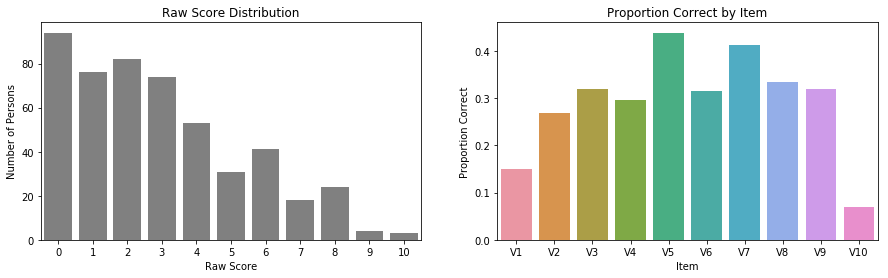

In [4]:
plt.rcParams["figure.figsize"] = (15,4)
sns.set_palette("husl")
f, (ax1, ax2) = plt.subplots(1, 2)

# raw score distribution
raw_score_dist = df.sum(axis='columns').value_counts().sort_index()
ax1.set_title('Raw Score Distribution')
ax1.set_xlabel('Raw Score')
ax1.set_ylabel('Number of Persons')
sns.barplot(raw_score_dist.index, raw_score_dist, ax=ax1, color='grey')

# performance by item
prop_correct = df.sum() / df.shape[0]
ax2.set_title('Proportion Correct by Item')
ax2.set_xlabel('Item')
ax2.set_ylabel('Proportion Correct')
sns.barplot(prop_correct.index, prop_correct, ax=ax2)

plt.show()

# 2 Models

I want to predict the probability that a particular person will provide a particular response to an item. I denote the probability of a correct response as $P_{ij}(y_{ij}=1 \mid \theta_j,b_i)$, for each response $y_{ij}$ to item $i$ by person $j$. The probability of a correct response depends on both a person's ability $\theta_j$ and the properties of the item $b_i, c_i, a_i,$ etc.

## 2.1 One-Parameter Logistic (1PL)

The 1PL item response function is

$$P_{ij}(y_{ij}=1 \mid \theta_j,b_i) = \frac{exp(\theta_j-b_i)}{1+exp(\theta_j-b_i)},$$

where $b_i$ is the item difficulty.

The 1PL model, also known as the Rasch model, can be fit to the response matrix by...

### 2.1.1 Stan Implementation

Implementation of the Rasch model using PyStan and edstan (https://github.com/danielcfurr/edstan-python).

In [5]:
# Use the response matrix to create an EdstanData instance
ed_1 = edstan.EdstanData(response_matrix = df)

# Fit the Rasch model
fit_1 = ed_1.fit_model('rasch', iter = 200, chains = 4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fdab647972a401155d6ee7e515fd4ba5 NOW.
/Users/lukasolson/anaconda3/envs/stan_env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/cl/ch5nhgzn26ngszgrdfktvgy00000gn/T/tmp9k01m9tp/stanfit4anon_model_fdab647972a401155d6ee7e515fd4ba5_7114560534145468911.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Rasch model
Inference for Stan model: anon_model_fdab647972a401155d6ee7e515fd4ba5.
4 chains, each with iter=200; warmup=100; thin=1; 
post-warmup draws per chain=100, total post-warmup draws=400.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Item 0
  beta[1]         0.98  9.0e-3   0.15    0.7   0.88   0.99    1.1   1.26    263   1.01
Item 1
  beta[2]         0.04  5.7e-3   0.12  -0.19  -0.04   0.04   0.12    0.3    440   0.99
Item 2
  beta[3]        -0.26  5.8e-3   0.11  -0.48  -0.34  -0.26  -0.18  -0.07    371    1.0
Item 3
  beta[4]        -0.14  6.7e-3   0.12  -0.37  -0.22  -0.14  -0.06    0.1    312   1.01
Item 4
  beta[5]        -0.96  5.3e-3    0.1  -1.14  -1.02  -0.96  -0.89  -0.76    346    1.0
Item 5
  beta[6]        -0.23  5.6e-3    0.1  -0.44   -0.3  -0.23  -0.16  -0.01    337    1.0
Item 6
  beta[7]        -0.81  4.7e-3    0.1   -1.0  -0.87  -0.81  -0.74   -0.6    433   0.99
Item 7
  beta[8]        -0.36  5.2e-3   0.11  -0.58  -0.43

# 3 Results

Now that the model is fit, I can observe the item characteristic curves and item information curves. I calculate the values for each curve using the CATSim package.

### 3.1.1 Stan Implementation

I generate the item characteristic curve by calculating the probability of a correct response, given by the above equation, for every value of theta. The item information curve is the derivative of the ICC. Finally, the test information curve is the sum of the IICs.

In [15]:
def icc_1pl(theta, b):
    return 1 / (1 + np.exp(-(theta - b)))

def inf_1pl(p_theta):
    return p_theta * (1 - p_theta)


def icc_4pl(theta, a, b, c=0, d=1):
    return c + ((d - c) / (1 + np.exp(-a * (theta - b))))

def inf_4pl(theta, a, b, c=0, d=1):
    
    p_theta = icc_4pl(theta, a, b, c, d)

    return ((a**2) * ((p_theta - c)**2) * ((d - p_theta)**2)) / (
        ((d - c)**2) * p_theta * (1 - p_theta)
    )

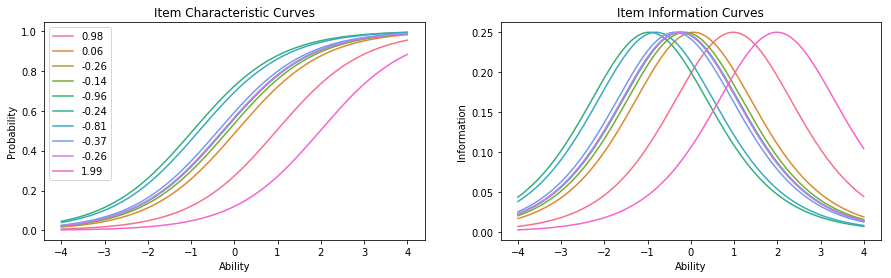

In [22]:
plt.rcParams["figure.figsize"] = (15,4)
sns.set_palette("husl", 10)
f, (ax1, ax2) = plt.subplots(1, 2)

theta = np.linspace(-4, 4, 256, endpoint=True)
# beta = [1.26, 0.3, -0.07, 0.1, -0.76, -0.01, -0.6, -0.16, -0.07, 2.33]
beta = [0.98, 0.06, -0.26, -0.14, -0.96, -0.24, -0.81, -0.37, -0.26, 1.99] # TODO: figure out how to extract params from stan
for b in beta:
    p_theta = icc_1pl(theta, b)
    sns.lineplot(theta, p_theta, ax=ax1)
    sns.lineplot(theta, inf_1pl(p_theta), ax=ax2)
    
ax1.set_title('Item Characteristic Curves')
ax1.set_xlabel('Ability')
ax1.set_ylabel('Probability')

ax2.set_title('Item Information Curves')
ax2.set_xlabel('Ability')
ax2.set_ylabel('Information')

ax1.legend(beta)

plt.show()

Unfortunately, at this point it is clear to me that my results do not match those of the tutorial I am following. The IIC should look like this:

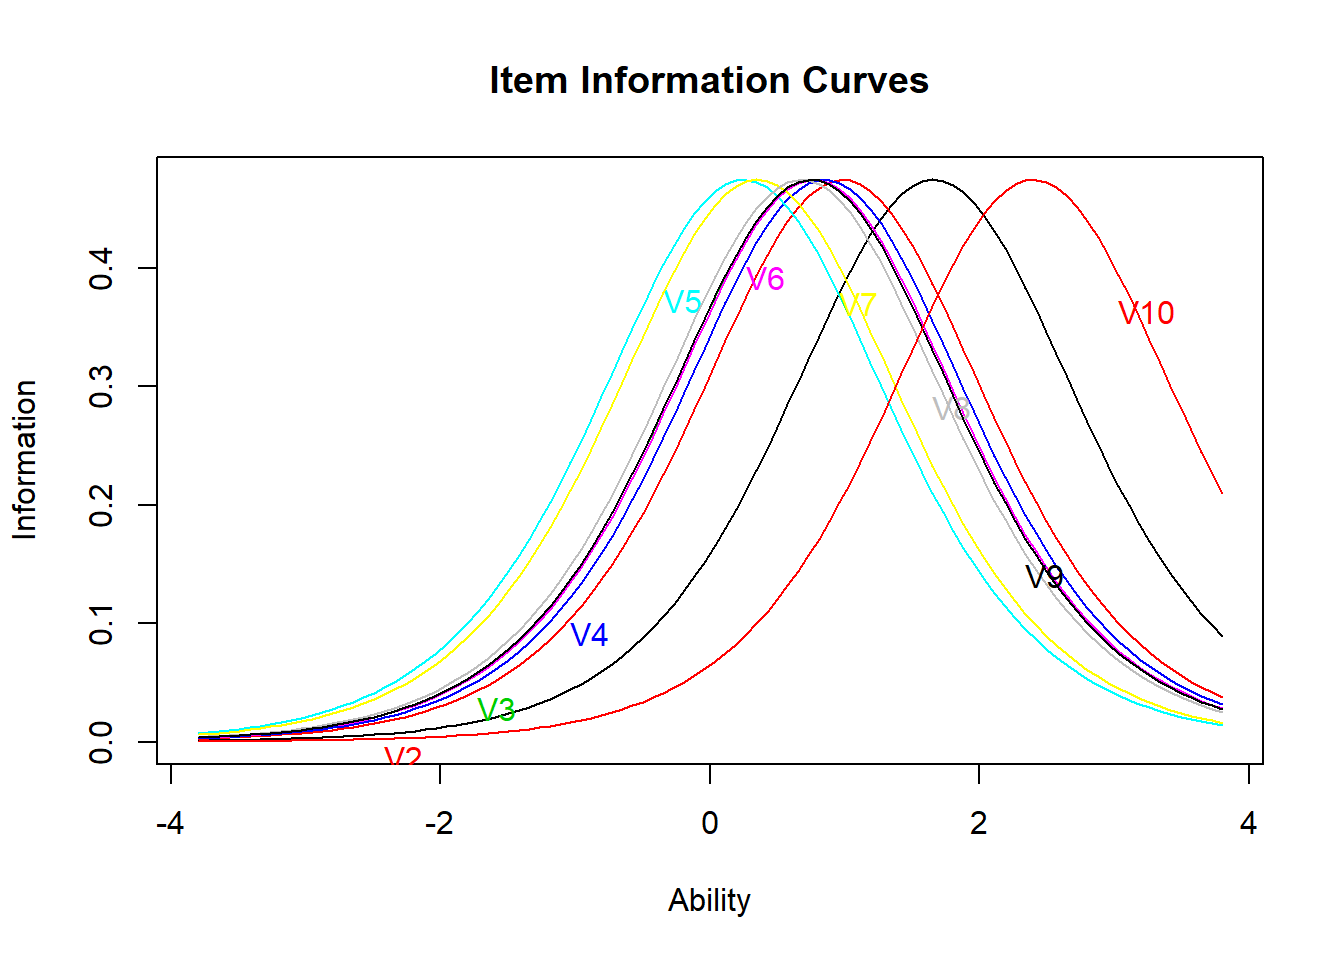

This may be because I am using a different estimation method. I need to double check my code for bugs and validate the models.

https://www.youtube.com/watch?v=BRYipKwPmW4&list=PLJNUIJnElUzDmrIPunMyF3tTvIHb65wNb&index=5
According to this video, however, the item information is equal to $P*(1-P)$ and therefore peaks at 0.25 (because $0.5*(1-0.5)=0.25$). This clearly indicates an error in the tutorial's visualization: it should peak at 0.25, not 0.5. That lends credibility to my analysis, even though I still do not fully understand the model fit.

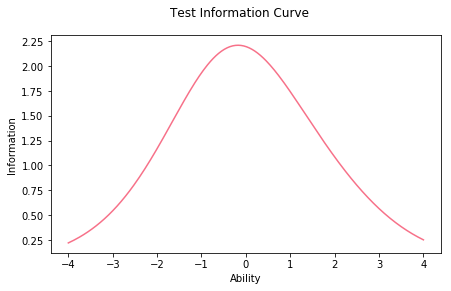

In [18]:
# Test Information Curve

test_inf = []
for b in beta:
    p_theta = icc_1pl(theta, b)
    test_inf.append(inf_1pl(p_theta))
    
plt.rcParams["figure.figsize"] = (7,4)
plt.plot(theta, np.sum(test_inf, axis=0))

plt.suptitle('Test Information Curve')
plt.xlabel('Ability')
plt.ylabel('Information')

plt.show()

# 4 Conclusion

## 4.1 

## 4.2 Next Steps

I plan to expand on the above analysis by implementing 2PL and 3PL models. I would also like to try out some of the other available Python libraries built for IRT.

# 5 References

I found the following sources helpful in learning about IRT and conducting this analysis.

1. https://quantdev.ssri.psu.edu/tutorials/introduction-irt-modeling
2. https://mc-stan.org/users/documentation/case-studies/tutorial_twopl.html
3. https://www.metheval.uni-jena.de/irt/VisualIRT.pdf

I also learned about using LaTeX in Jupyter notebooks and found this post helpful: https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference